### A/B Testing with Cookie Cats

Cookie Cats is a mobile game where players must connect tiles of the same color to clear the board and win the level. It's like Candy Crush but it features singing cats and cookies. Occasionally players encounter gates that force them to wait an amoujnt of time to progress. The purpose of these gates is to give players an enforced break from the game, hopefully resulting in prolonged enjoyement of the game. 

This A/B test analyzes whether the gate should be placed at level 30 or level 40. The gate is currently placed at level 30. 

In [3]:
import pandas as pd

# Reading in the data
file_path = 'C:/Users/Alma Chen/Documents/Data Projects/AB Testing with Cookie Cats/datasets/'
df = pd.read_csv(file_path + "cookie_cats.csv")


print(df.head())

   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True


In [4]:
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


The data is from approximately 90,000 users. The colums of the data frame are: 
     <li> user_id: identifies each player
     <li> version: whether a player was played in control (gate_30) or the group with the gate at level 40 (gate_40) 
     <li> sum_gamerounds: the number of games played during the first 14 days after install
     <li> retention_1: did the player come back 1 days after installing?
     <li> retention_7: did the player come back 7 days after installing? 
         
We can see that there are roughly the same number of players in gate_30 and gate_40. 

Text(0, 0.5, 'Number of Users')

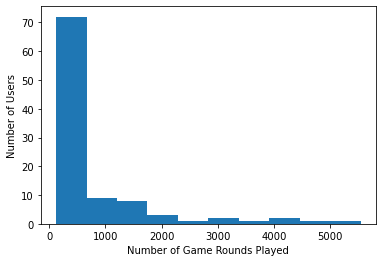

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# Counting the number of players for each number of gamerounds 
plot_df = df.groupby('sum_gamerounds').count()

# Plotting the distribution of players that played 0 to 100 game rounds
fig, ax = plt.subplots()
ax.hist(plot_df.head(100)['userid'])
ax.set_xlabel("Number of Game Rounds Played")
ax.set_ylabel("Number of Users")

For fun, the distribution of the number of game rounds played is shown above. For this A/B test, number og game rounds played will not be used. 

In [6]:

#Overall 1 day retention 
print(df['retention_1'].sum()/df['retention_1'].count())

0.4452095044850259


In [7]:
print(df.groupby('version')['retention_1'].sum()/df.groupby('version')['retention_1'].count())
                           

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64


Overall 44.5% of players come back and play the game one day after installing. However, the 1-day retention of players assigned to gate 40 is 0.6% lower than those assigned the control. Is this difference significant? 

To answer this question, the sample is repeatedly re-sampled (with replacement) to calculate 1-day rentention. The variance in these calculated 1-day retentions will give an idea of whether the difference is significant. 

In [1]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
iterations = 500
#iterations set to 500 to be quick. In production this number can be set to 10,000.


for i in range(iterations):
    boot_mean = df.sample(frac=1, replace = True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
print(boot_1d.head())
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot.kde()


NameError: name 'df' is not defined

A column with the % difference between the two groups is plotted to better visualize the difference. The graph has the highest density with the difference is between 1-2%. 

Text(0.5, 0, 'Difference between gate_30 and gate_40 (x100)')

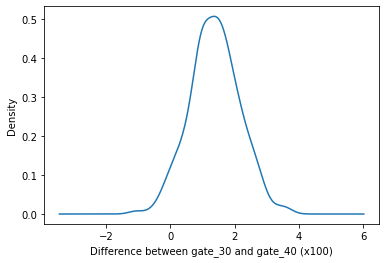

In [9]:
boot_1d['diff'] = (boot_1d['gate_30']-boot_1d['gate_40'])/boot_1d['gate_40']*100

# Ploting the bootstrap % difference
fig, ax = plt.subplots()

#ax=boot_1d.plot.kde('diff')
ax = boot_1d['diff'].plot.kde()
ax.set_xlabel('Difference between gate_30 and gate_40 (x100)')

In [10]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob = sum(boot_1d['diff']>0)/len(boot_1d)
print('{:.1%}'.format(prob))

96.2%


The probability that the difference is greater than 0 is 96.2%. 
It also makes sense to look at 7-day retention.

In [ ]:
# Calculating 7-day retention for both AB-groups
print(df.groupby('version')['retention_7'].sum()/df.groupby('version')['retention_7'].count())

100.0%


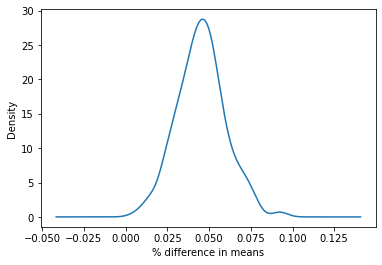

In [12]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace = True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d['gate_30']-boot_7d['gate_40'])/boot_7d['gate_40']

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot.kde()
ax.set_xlabel("% difference in means")

# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = sum(boot_7d['diff']>0)/len(boot_7d)

# Pretty printing the probability
print('{:.1%}'.format(prob))

    
# # A Kernel Density Estimate plot of the bootstrap distributions

With the 7-day retention, the retention is 0.8% lower when the gate is at level 40 than when it is at level 30. The overall 7-day retention is lower than the overall 1-day retention. 

With 7-day retention, the probability that difference of retentions between gates is greater than 0 is 100%. If we want to keep both 1 and 7 day retention high, the gate should be kept at level 30. 

For further analysis, other methods such as in-app purchases, time spent playing the game, or the number of rounds played could be explored. 